# **Prediction of Genetic Mutation from Clinical Data of Cystic Fibrosis using Few-Shot Siamese Bidirectional LSTM**
---
Members:
1. Salman Alam (19301037)
2. Atquiya Labiba Oni (19301039)
---
Dataset: https://springernature.figshare.com/articles/dataset/Additional_file_1_of_Haematological_abnormalities_in_children_with_sickle_cell_disease_and_non-severe_malaria_infection_in_western_Kenya/14385679/1


# Load Dataset

In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from random import sample
from numpy import random
from collections import Counter

#Impute
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

#Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, Lambda, Bidirectional, Dropout
from keras.models import Model
import keras.backend as K

#importing outcome techniques
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CSE437_Project/CSE437_Project/Dataset01.csv')
df

,Unnamed: 0,PAIR NUMBER,DIAGNOSED BY NEONATAL SCREENING (NBS),MECONIUM ILEUS (MI),DIOS (D),SWEAT CHLORIDE AT DIAGNOSIS (mEq/L),CFTR GENOTYPE,PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY),"RECURRENT PANCREATITIS, REC",I FEV1%,INTERMEDIATE FEV1%,LAST FEV1% AVAILABLE SEVERE LUNG DISEASE,P. AERUGINOSA COLONIZATION,MRSA COLONIZATION,S. AUREUS COLONIZATION,S. MALTOPHILIA COLONIZATION,B. CEPACIA COLONIZATION,CF LIVER DISEASE,CF RELATED DIABETES,NASAL POLYPOSIS REQUIRING SURGERY (NP)
0,1.0,1:00 AM,NaN,NaN,NaN,112,F508del/E831X,I,NaN,100.0,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1 B,NaN,NaN,NaN,120,F508del/E831X,I,NaN,100.0,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,2:00 AM,NaN,NaN,NaN,104,I1234V/I1234V,S,NaN,26.0,30.0,10.0,CHR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2 B,NaN,NaN,NaN,96,I1234V/I1234V,S,NaN,70.0,64.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,3:00 AM,NBS,NaN,NaN,107,"G85E/[R117L,L997F]",S,NaN,110.0,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,40.0,20 B,NaN,NaN,NaN,100,F508del/F508del,I,NaN,99.0,NaN,35.0,CHR,NaN,NaN,NaN,NaN,NaN,CFRD,NaN
204,11.0,6:00 AM,NaN,NaN,NaN,93,F508del/G542X,I,NaN,100.0,102.0,112.0,CHR,NaN,NaN,NaN,NaN,NO,NaN,NP
205,12.0,6 B,NaN,NaN,NaN,74,F508del/G542X,I,NaN,NaN,97.0,86.0,NaN,NaN,NaN,NaN,NaN,"CIRRHOSIS, PORTAL HYP",CFRD,NP
206,13.0,7:00 AM,NaN,MI,NaN,98,F508del/621+1G->T,I,NaN,54.0,48.0,34.0,NaN,NaN,NaN,NaN,CHR,"CIRRHOSIS, PORTAL HYP",NaN,NaN


# Dataset Analysis

### General Info

In [ ]:
df.shape

(208, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 20 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            202 non-null    float64
 1   PAIR NUMBER                                           202 non-null    object 
 2   DIAGNOSED BY NEONATAL SCREENING (NBS)                 37 non-null     object 
 3   MECONIUM ILEUS (MI)                                   14 non-null     object 
 4   DIOS (D)                                              6 non-null      object 
 5   SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)                   202 non-null    object 
 6   CFTR GENOTYPE                                         202 non-null    object 
 7   PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)  202 non-null    object 
 8   RECURRENT PANCREATITIS, REC                           9 non-

### Check Null Values

In [ ]:
df.isnull().sum()

Unnamed: 0                                                6
PAIR NUMBER                                               6
DIAGNOSED BY NEONATAL SCREENING (NBS)                   171
MECONIUM ILEUS (MI)                                     194
DIOS (D)                                                202
SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)                       6
CFTR GENOTYPE                                             6
PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)      6
RECURRENT PANCREATITIS, REC                             199
I FEV1%                                                 124
INTERMEDIATE FEV1%                                      176
LAST FEV1% AVAILABLE  SEVERE LUNG DISEASE                10
P. AERUGINOSA COLONIZATION                              117
MRSA COLONIZATION                                       198
S. AUREUS COLONIZATION                                  117
S. MALTOPHILIA COLONIZATION                             202
B. CEPACIA COLONIZATION                 

### Multi-class Label Analysis

In [ ]:
df['CFTR GENOTYPE'].unique()

array(['F508del/E831X', 'I1234V/I1234V', 'G85E/[R117L,L997F]',
       'R334W/G85E', 'F508del/2789+5G>A', 'Q220X/A1006E', 'N1303K/G1244E',
       'F508del/P5L', 'R347P/2184insA', 'F508del/U', 'F508del/G542X',
       'F508del/N1303K', '2789+5G>A/1342-2A>C', 'F508del/W1282X',
       'E1104X/E1104X', 'F508del/F508del', nan, 'R374P/R374P',
       'F508del/711+3A>G', 'F508del/S1455X', 'F508del/E585X',
       'L1077P/[E504X-1898+73T->G]', 'DELe2/C1002-1110_1113DEL',
       '2789+5G->A/DELe2', 'F508del/DUPe19', 'F508del/R334W',
       'F508del/3878delG', 'F508del/G1244E', '[R74W,V201M,D1270N]/N1303K',
       'G542X/4016insT', 'F508del/F508del ', 'F508del/3849+10kbC',
       '3272-26A>G/E585X', 'G542X/711+3A>G', 'G542X/U',
       'F508del/876-10del8', 'W1282X/Q1291R', 'F508del/R553X',
       'F508del/DELe22-24', 'F508del/D110H', 'F508del/D110H ',
       'R553X/2789+5G>A', 'F508del/I1234V', 'G542X/S549R(T>G)',
       'F508del/Q1476X', 'N1303K/2789+5G>A', 'F508del/S945L',
       'F508del/S549N', 

In [ ]:
df['CFTR GENOTYPE'].value_counts().nlargest(60)

F508del/F508del               21
F508del/G542X                 12
F508del/N1303K                10
F508del/F508del                8
F508del/2789+5G>A              8
F508del/U                      6
F508del/G1244E                 5
2789+5G>A/2789+5G>A            5
F508del/E831X                  4
F508del/R553X                  4
F508del/P5L                    4
F508del/W1282X                 4
F508del/D579G                  3
F508del/D614G                  3
N1303K/G542X                   3
F508del/DELe14B_17B            3
DELe22_24/DELe22_24            2
F508del/S549R(A>C)             2
R553X/2789+5G>A                2
F508del/I1234V                 2
G542X/S549R(T>G)               2
F508del/Q1476X                 2
N1303K/2789+5G>A               2
F508del/G85E                   2
F508del/S945L                  2
F508del/S549N                  2
DELe 22_24/DELe 22_24          2
R334W/[R117L;L997F]            2
2789+5G>A/H1375P               2
2789+5G>A/L1077P               2
L1065P/T33

# Data Pre-processing

## Fill Empty Data

In [ ]:
df['RECURRENT PANCREATITIS, REC '].unique()

array([nan, 'REC '], dtype=object)

In [ ]:
df.columns

Index(['Unnamed: 0', 'PAIR NUMBER', 'DIAGNOSED BY NEONATAL SCREENING (NBS)',
       'MECONIUM ILEUS (MI)', 'DIOS (D)',
       'SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)', 'CFTR GENOTYPE',
       'PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)',
       'RECURRENT PANCREATITIS, REC ', 'I FEV1% ', 'INTERMEDIATE FEV1% ',
       'LAST FEV1% AVAILABLE  SEVERE LUNG DISEASE',
       'P. AERUGINOSA COLONIZATION', 'MRSA COLONIZATION',
       'S. AUREUS COLONIZATION', 'S. MALTOPHILIA COLONIZATION',
       'B. CEPACIA COLONIZATION ', 'CF LIVER DISEASE ', 'CF RELATED DIABETES',
       'NASAL POLYPOSIS REQUIRING SURGERY (NP)'],
      dtype='object')

In [ ]:
df.loc[df["DIAGNOSED BY NEONATAL SCREENING (NBS)"] != "NBS", "DIAGNOSED BY NEONATAL SCREENING (NBS)"] = "No"
df.loc[df["MECONIUM ILEUS (MI)"] != "MI", "MECONIUM ILEUS (MI)"] = "No"
df.loc[df["DIOS (D)"] != "D", "DIOS (D)"] = "No"
df.loc[df['RECURRENT PANCREATITIS, REC '] != 'REC ', 'RECURRENT PANCREATITIS, REC '] = "No"
df.loc[df["P. AERUGINOSA COLONIZATION"] != "CHR", "P. AERUGINOSA COLONIZATION"] = "No"
df.loc[df["MRSA COLONIZATION"] != "CHR", "MRSA COLONIZATION"] = "No"
df.loc[df["S. AUREUS COLONIZATION"] != "CHR", "S. AUREUS COLONIZATION"] = "No"
df.loc[df["S. MALTOPHILIA COLONIZATION"] != "CHR", "S. MALTOPHILIA COLONIZATION"] = "No"
df.loc[df["B. CEPACIA COLONIZATION "] != "CHR", "B. CEPACIA COLONIZATION "] = "No"
df.loc[df["CF LIVER DISEASE "] != "CIRRHOSIS", "CF LIVER DISEASE "] = "No"
df.loc[df["CF RELATED DIABETES"] != "CFRD", "CF RELATED DIABETES"] = "No"
df.loc[df["NASAL POLYPOSIS REQUIRING SURGERY (NP)"] != "NP", "NASAL POLYPOSIS REQUIRING SURGERY (NP)"] = "No"

In [ ]:
df.loc[df["SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)"] == " >60", "SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)"] = np.nan
df['SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)'] = df['SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)'].astype(float)

### Categorical Imputation

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

column_trans = ColumnTransformer([('CFTR GENOTYPE', imputer, [6]),
                                 ('PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)', imputer, [7])],
                                 remainder='passthrough')

column_names = ['CFTR GENOTYPE', 'PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)',
       'Unnamed: 0', 'PAIR NUMBER',
       'DIAGNOSED BY NEONATAL SCREENING (NBS)',
       'MECONIUM ILEUS (MI)', 'DIOS (D)',
       'SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)',
       'RECURRENT PANCREATITIS, REC ', 'I FEV1% ', 'INTERMEDIATE FEV1% ',
       'LAST FEV1% AVAILABLE  SEVERE LUNG DISEASE',
       'P. AERUGINOSA COLONIZATION', 'MRSA COLONIZATION',
       'S. AUREUS COLONIZATION', 'S. MALTOPHILIA COLONIZATION',
       'B. CEPACIA COLONIZATION ', 'CF LIVER DISEASE ', 'CF RELATED DIABETES',
       'NASAL POLYPOSIS REQUIRING SURGERY (NP)']
df = column_trans.fit_transform(df)

df = pd.DataFrame(df, columns = column_names).reset_index(drop='index')
df

,CFTR GENOTYPE,PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY),Unnamed: 0,PAIR NUMBER,DIAGNOSED BY NEONATAL SCREENING (NBS),MECONIUM ILEUS (MI),DIOS (D),SWEAT CHLORIDE AT DIAGNOSIS (mEq/L),"RECURRENT PANCREATITIS, REC",I FEV1%,INTERMEDIATE FEV1%,LAST FEV1% AVAILABLE SEVERE LUNG DISEASE,P. AERUGINOSA COLONIZATION,MRSA COLONIZATION,S. AUREUS COLONIZATION,S. MALTOPHILIA COLONIZATION,B. CEPACIA COLONIZATION,CF LIVER DISEASE,CF RELATED DIABETES,NASAL POLYPOSIS REQUIRING SURGERY (NP)
0,F508del/E831X,I,1.0,1:00 AM,No,No,No,112.0,No,100.0,NaN,99.0,No,No,No,No,No,No,No,No
1,F508del/E831X,I,2.0,1 B,No,No,No,120.0,No,100.0,NaN,101.0,No,No,No,No,No,No,No,No
2,I1234V/I1234V,S,3.0,2:00 AM,No,No,No,104.0,No,26.0,30.0,10.0,CHR,No,No,No,No,No,No,No
3,I1234V/I1234V,S,4.0,2 B,No,No,No,96.0,No,70.0,64.0,71.0,No,No,No,No,No,No,No,No
4,"G85E/[R117L,L997F]",S,5.0,3:00 AM,NBS,No,No,107.0,No,110.0,NaN,96.0,No,No,No,No,No,No,No,NP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,F508del/F508del,I,40.0,20 B,No,No,No,100.0,No,99.0,NaN,35.0,No,No,No,No,No,No,CFRD,No
204,F508del/G542X,I,11.0,6:00 AM,No,No,No,93.0,No,100.0,102.0,112.0,CHR,No,No,No,No,No,No,NP
205,F508del/G542X,I,12.0,6 B,No,No,No,74.0,No,NaN,97.0,86.0,No,No,No,No,No,No,No,NP
206,F508del/621+1G->T,I,13.0,7:00 AM,No,MI,No,98.0,No,54.0,48.0,34.0,No,No,No,No,CHR,No,No,No


## Encoding

In [ ]:
columns = ['DIAGNOSED BY NEONATAL SCREENING (NBS)', 'MECONIUM ILEUS (MI)',
       'DIOS (D)',
       'P. AERUGINOSA COLONIZATION', 'MRSA COLONIZATION',
       'S. AUREUS COLONIZATION', 'S. MALTOPHILIA COLONIZATION',
       'B. CEPACIA COLONIZATION ', 'CF LIVER DISEASE ', 'CF RELATED DIABETES',
       'NASAL POLYPOSIS REQUIRING SURGERY (NP)', 'RECURRENT PANCREATITIS, REC ']
enc = LabelEncoder()
for i in columns:
  df[i] = enc.fit_transform(df[i])

In [ ]:
df.loc[((df["CFTR GENOTYPE"] != "F508del/F508del") & (df["CFTR GENOTYPE"] != "F508del/G542X") & (df["CFTR GENOTYPE"] != "F508del/N1303K")), "CFTR GENOTYPE"] = "other"

df["CFTR GENOTYPE"].unique()

array(['other', 'F508del/G542X', 'F508del/N1303K', 'F508del/F508del'],
      dtype=object)

In [ ]:
df["CFTR GENOTYPE"] = df["CFTR GENOTYPE"].map({'F508del/F508del':0, 'F508del/G542X':1, 'F508del/N1303K':2,'other':3})

In [ ]:
df['CFTR GENOTYPE'].value_counts()

3    159
0     27
1     12
2     10
Name: CFTR GENOTYPE, dtype: int64

In [ ]:
df['PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)'] = df['PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)'].map({'S':0, 'I':1})

In [ ]:
df['PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)'].value_counts()

1    125
0     83
Name: PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY), dtype: int64

## Drop Unnecessary Columns

In [ ]:
to_drop = ['Unnamed: 0', 'PAIR NUMBER']

# Drop those columns from the DataFrame
df = df.drop(to_drop, axis=1)
df

,CFTR GENOTYPE,PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY),DIAGNOSED BY NEONATAL SCREENING (NBS),MECONIUM ILEUS (MI),DIOS (D),SWEAT CHLORIDE AT DIAGNOSIS (mEq/L),"RECURRENT PANCREATITIS, REC",I FEV1%,INTERMEDIATE FEV1%,LAST FEV1% AVAILABLE SEVERE LUNG DISEASE,P. AERUGINOSA COLONIZATION,MRSA COLONIZATION,S. AUREUS COLONIZATION,S. MALTOPHILIA COLONIZATION,B. CEPACIA COLONIZATION,CF LIVER DISEASE,CF RELATED DIABETES,NASAL POLYPOSIS REQUIRING SURGERY (NP)
0,3,1,1,1,1,112.0,0,100.0,NaN,99.0,1,1,1,1,1,1,1,1
1,3,1,1,1,1,120.0,0,100.0,NaN,101.0,1,1,1,1,1,1,1,1
2,3,0,1,1,1,104.0,0,26.0,30.0,10.0,0,1,1,1,1,1,1,1
3,3,0,1,1,1,96.0,0,70.0,64.0,71.0,1,1,1,1,1,1,1,1
4,3,0,0,1,1,107.0,0,110.0,NaN,96.0,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0,1,1,1,1,100.0,0,99.0,NaN,35.0,1,1,1,1,1,1,0,1
204,1,1,1,1,1,93.0,0,100.0,102.0,112.0,0,1,1,1,1,1,1,0
205,1,1,1,1,1,74.0,0,NaN,97.0,86.0,1,1,1,1,1,1,1,0
206,3,1,1,0,1,98.0,0,54.0,48.0,34.0,1,1,1,1,0,1,1,1


## Imputation

In [ ]:
imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
df

,CFTR GENOTYPE,PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY),DIAGNOSED BY NEONATAL SCREENING (NBS),MECONIUM ILEUS (MI),DIOS (D),SWEAT CHLORIDE AT DIAGNOSIS (mEq/L),"RECURRENT PANCREATITIS, REC",I FEV1%,INTERMEDIATE FEV1%,LAST FEV1% AVAILABLE SEVERE LUNG DISEASE,P. AERUGINOSA COLONIZATION,MRSA COLONIZATION,S. AUREUS COLONIZATION,S. MALTOPHILIA COLONIZATION,B. CEPACIA COLONIZATION,CF LIVER DISEASE,CF RELATED DIABETES,NASAL POLYPOSIS REQUIRING SURGERY (NP)
0,3.0,1.0,1.0,1.0,1.0,112.0,0.0,100.0,88.6,99.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,3.0,1.0,1.0,1.0,1.0,120.0,0.0,100.0,88.6,101.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.0,0.0,1.0,1.0,1.0,104.0,0.0,26.0,30.0,10.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3.0,0.0,1.0,1.0,1.0,96.0,0.0,70.0,64.0,71.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,3.0,0.0,0.0,1.0,1.0,107.0,0.0,110.0,93.0,96.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0,1.0,1.0,1.0,1.0,100.0,0.0,99.0,54.2,35.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
204,1.0,1.0,1.0,1.0,1.0,93.0,0.0,100.0,102.0,112.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
205,1.0,1.0,1.0,1.0,1.0,74.0,0.0,94.2,97.0,86.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
206,3.0,1.0,1.0,0.0,1.0,98.0,0.0,54.0,48.0,34.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


## Combine FEV1 Columns

In [ ]:
FEV_columns = ['I FEV1% ', 'INTERMEDIATE FEV1% ', 'LAST FEV1% AVAILABLE  SEVERE LUNG DISEASE']

# Use apply to create a mean column
df["FEV1%"] = df.apply(lambda row: row[FEV_columns].mean(), axis=1)

## Drop Unrelated Columns

In [ ]:
#Drop the rest
to_drop = ['I FEV1% ', 'INTERMEDIATE FEV1% ', 'LAST FEV1% AVAILABLE  SEVERE LUNG DISEASE', 'DIAGNOSED BY NEONATAL SCREENING (NBS)']

# Drop those columns from the DataFrame
df = df.drop(to_drop, axis=1)
df

,CFTR GENOTYPE,PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY),MECONIUM ILEUS (MI),DIOS (D),SWEAT CHLORIDE AT DIAGNOSIS (mEq/L),"RECURRENT PANCREATITIS, REC",P. AERUGINOSA COLONIZATION,MRSA COLONIZATION,S. AUREUS COLONIZATION,S. MALTOPHILIA COLONIZATION,B. CEPACIA COLONIZATION,CF LIVER DISEASE,CF RELATED DIABETES,NASAL POLYPOSIS REQUIRING SURGERY (NP),FEV1%
0,3.0,1.0,1.0,1.0,112.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,95.866667
1,3.0,1.0,1.0,1.0,120.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,96.533333
2,3.0,0.0,1.0,1.0,104.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,22.000000
3,3.0,0.0,1.0,1.0,96.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,68.333333
4,3.0,0.0,1.0,1.0,107.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,99.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0,1.0,1.0,1.0,100.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,62.733333
204,1.0,1.0,1.0,1.0,93.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,104.666667
205,1.0,1.0,1.0,1.0,74.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,92.400000
206,3.0,1.0,0.0,1.0,98.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,45.333333


## Outliers

In [ ]:
df.isnull().sum()

CFTR GENOTYPE                                           0
PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)    0
MECONIUM ILEUS (MI)                                     0
DIOS (D)                                                0
SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)                     0
RECURRENT PANCREATITIS, REC                             0
P. AERUGINOSA COLONIZATION                              0
MRSA COLONIZATION                                       0
S. AUREUS COLONIZATION                                  0
S. MALTOPHILIA COLONIZATION                             0
B. CEPACIA COLONIZATION                                 0
CF LIVER DISEASE                                        0
CF RELATED DIABETES                                     0
NASAL POLYPOSIS REQUIRING SURGERY (NP)                  0
FEV1%                                                   0
dtype: int64

In [ ]:
## storing names of columns in Column_Names
Column_Names=['SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)', 'FEV1%']

for j in Column_Names:
  df['zscore'] = (df[j] - df[j].mean())/df[j].std()
  df.loc[((df.zscore>2) | (df.zscore<-2)), j] = np.nan

df = df.drop('zscore', axis=1)

In [ ]:
df.isnull().sum()

CFTR GENOTYPE                                            0
PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)     0
MECONIUM ILEUS (MI)                                      0
DIOS (D)                                                 0
SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)                      7
RECURRENT PANCREATITIS, REC                              0
P. AERUGINOSA COLONIZATION                               0
MRSA COLONIZATION                                        0
S. AUREUS COLONIZATION                                   0
S. MALTOPHILIA COLONIZATION                              0
B. CEPACIA COLONIZATION                                  0
CF LIVER DISEASE                                         0
CF RELATED DIABETES                                      0
NASAL POLYPOSIS REQUIRING SURGERY (NP)                   0
FEV1%                                                   13
dtype: int64

In [ ]:
imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

# Data Corelation Analysis

## Heat-Map

In [ ]:
df.corr()

,CFTR GENOTYPE,PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY),MECONIUM ILEUS (MI),DIOS (D),SWEAT CHLORIDE AT DIAGNOSIS (mEq/L),"RECURRENT PANCREATITIS, REC",P. AERUGINOSA COLONIZATION,MRSA COLONIZATION,S. AUREUS COLONIZATION,S. MALTOPHILIA COLONIZATION,B. CEPACIA COLONIZATION,CF LIVER DISEASE,CF RELATED DIABETES,NASAL POLYPOSIS REQUIRING SURGERY (NP),FEV1%
CFTR GENOTYPE,1.000000,-0.384933,-0.085138,-0.089189,-0.205258,0.110053,0.055890,-0.053194,-0.102617,-0.008531,-0.022458,0.103552,0.207484,-0.158349,0.252275
PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY),-0.384933,1.000000,-0.179717,-0.140438,0.257438,-0.212729,-0.149382,-0.045451,-0.006185,-0.023124,-0.127885,-0.033199,-0.109917,0.083066,-0.137575
MECONIUM ILEUS (MI),-0.085138,-0.179717,1.000000,-0.046298,-0.100190,0.057129,-0.004598,0.119018,-0.082195,-0.046298,0.208391,0.098122,0.023100,-0.074782,-0.010248
DIOS (D),-0.089189,-0.140438,-0.046298,1.000000,-0.123448,-0.104525,-0.011471,0.095538,0.021713,-0.029703,-0.027048,-0.042644,-0.062244,-0.005056,0.075484
SWEAT CHLORIDE AT DIAGNOSIS (mEq/L),-0.205258,0.257438,-0.100190,-0.123448,1.000000,-0.084512,-0.152665,0.086267,0.068841,-0.075522,0.009785,0.040991,-0.101813,0.163095,-0.169096
"RECURRENT PANCREATITIS, REC",0.110053,-0.212729,0.057129,-0.104525,-0.084512,1.000000,0.014155,-0.062662,-0.050609,0.036652,0.033376,0.052621,0.002845,-0.210026,0.001451
P. AERUGINOSA COLONIZATION,0.055890,-0.149382,-0.004598,-0.011471,-0.152665,0.014155,1.000000,0.016155,-0.045283,-0.011471,-0.053902,0.026351,0.194714,0.116983,0.292609
MRSA COLONIZATION,-0.053194,-0.045451,0.119018,0.095538,0.086267,-0.062662,0.016155,1.000000,0.073616,0.095538,-0.035270,0.137164,0.059520,0.130530,0.084319
S. AUREUS COLONIZATION,-0.102617,-0.006185,-0.082195,0.021713,0.068841,-0.050609,-0.045283,0.073616,1.000000,0.021713,-0.075136,-0.010391,0.075836,0.096619,-0.040069
S. MALTOPHILIA COLONIZATION,-0.008531,-0.023124,-0.046298,-0.029703,-0.075522,0.036652,-0.011471,0.095538,0.021713,1.000000,-0.027048,0.080551,-0.062244,0.070057,-0.010082


<Axes: >

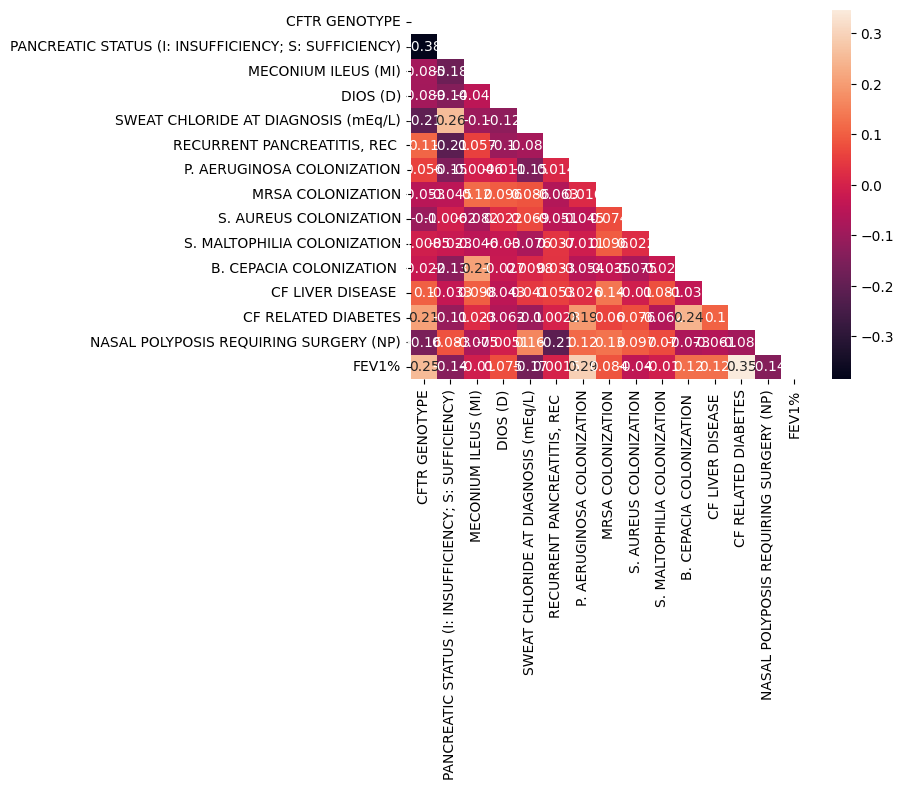

In [ ]:
corr= df.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask
sns.heatmap(corr, annot=True, mask=matrix)

In [ ]:
df['RECURRENT PANCREATITIS, REC '].value_counts()

0.0    199
1.0      9
Name: RECURRENT PANCREATITIS, REC , dtype: int64

#Split and Scale

In [ ]:
df

,CFTR GENOTYPE,PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY),MECONIUM ILEUS (MI),DIOS (D),SWEAT CHLORIDE AT DIAGNOSIS (mEq/L),"RECURRENT PANCREATITIS, REC",P. AERUGINOSA COLONIZATION,MRSA COLONIZATION,S. AUREUS COLONIZATION,S. MALTOPHILIA COLONIZATION,B. CEPACIA COLONIZATION,CF LIVER DISEASE,CF RELATED DIABETES,NASAL POLYPOSIS REQUIRING SURGERY (NP),FEV1%
0,3.0,1.0,1.0,1.0,112.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,95.866667
1,3.0,1.0,1.0,1.0,120.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,96.533333
2,3.0,0.0,1.0,1.0,104.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,91.120000
3,3.0,0.0,1.0,1.0,96.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,68.333333
4,3.0,0.0,1.0,1.0,107.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,99.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0,1.0,1.0,1.0,100.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,62.733333
204,1.0,1.0,1.0,1.0,93.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,104.666667
205,1.0,1.0,1.0,1.0,74.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,92.400000
206,3.0,1.0,0.0,1.0,98.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,45.333333


In [ ]:
X = df.loc[:, df.columns != 'CFTR GENOTYPE']
y = df.loc[:, df.columns == 'CFTR GENOTYPE']

In [ ]:
oversample = SMOTE(k_neighbors = 1, random_state=42)
X,y = oversample.fit_resample(X,y)
df = pd.concat([X,y], axis=1)

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify = df['CFTR GENOTYPE'])

In [ ]:
train_data['CFTR GENOTYPE'].value_counts()

1.0    112
0.0    111
3.0    111
2.0    111
Name: CFTR GENOTYPE, dtype: int64

In [ ]:
test_data['CFTR GENOTYPE'].value_counts()

0.0    48
3.0    48
2.0    48
1.0    47
Name: CFTR GENOTYPE, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_data[['MECONIUM ILEUS (MI)',
       'DIOS (D)', 'SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)',
       'PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)',
       'P. AERUGINOSA COLONIZATION', 'MRSA COLONIZATION',
       'S. AUREUS COLONIZATION', 'S. MALTOPHILIA COLONIZATION',
       'B. CEPACIA COLONIZATION ', 'CF LIVER DISEASE ', 'CF RELATED DIABETES',
       'NASAL POLYPOSIS REQUIRING SURGERY (NP)', 'RECURRENT PANCREATITIS, REC ',
       'FEV1%']] = scaler.fit_transform(train_data[['MECONIUM ILEUS (MI)',
       'DIOS (D)', 'SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)',
       'PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)',
       'P. AERUGINOSA COLONIZATION', 'MRSA COLONIZATION',
       'S. AUREUS COLONIZATION', 'S. MALTOPHILIA COLONIZATION',
       'B. CEPACIA COLONIZATION ', 'CF LIVER DISEASE ', 'CF RELATED DIABETES',
       'NASAL POLYPOSIS REQUIRING SURGERY (NP)', 'RECURRENT PANCREATITIS, REC ',
       'FEV1%']])

test_data[['MECONIUM ILEUS (MI)',
       'DIOS (D)', 'SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)',
       'PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)',
       'P. AERUGINOSA COLONIZATION', 'MRSA COLONIZATION',
       'S. AUREUS COLONIZATION', 'S. MALTOPHILIA COLONIZATION',
       'B. CEPACIA COLONIZATION ', 'CF LIVER DISEASE ', 'CF RELATED DIABETES',
       'NASAL POLYPOSIS REQUIRING SURGERY (NP)', 'RECURRENT PANCREATITIS, REC ',
       'FEV1%']] = scaler.transform(test_data[['MECONIUM ILEUS (MI)',
       'DIOS (D)', 'SWEAT CHLORIDE AT DIAGNOSIS (mEq/L)',
       'PANCREATIC STATUS (I: INSUFFICIENCY; S: SUFFICIENCY)',
       'P. AERUGINOSA COLONIZATION', 'MRSA COLONIZATION',
       'S. AUREUS COLONIZATION', 'S. MALTOPHILIA COLONIZATION',
       'B. CEPACIA COLONIZATION ', 'CF LIVER DISEASE ', 'CF RELATED DIABETES',
       'NASAL POLYPOSIS REQUIRING SURGERY (NP)', 'RECURRENT PANCREATITIS, REC ',
       'FEV1%']])

# Few-Shot Siamese Bi-LSTM

In [ ]:
patient_left = []
patient_right = []
target = []

genotype_codes = train_data['CFTR GENOTYPE'].unique()

for code in genotype_codes:
    similar = (train_data[train_data['CFTR GENOTYPE'] == code]).loc[:, train_data.columns != 'CFTR GENOTYPE']
    similar = similar.to_numpy()

    group_pairs = list(itertools.combinations(similar, 2))
    positive_pairs = sample(group_pairs, 2000) if len(group_pairs) > 2000 else group_pairs
    #positive_pairs = group_pairs
    patient_left.extend([p[0] for p in positive_pairs])
    patient_right.extend([p[1] for p in positive_pairs])
    target.extend([1.]*len(positive_pairs))

    other = (train_data[train_data['CFTR GENOTYPE'] != code]).loc[:, train_data.columns != 'CFTR GENOTYPE']
    other = other.to_numpy()
    for i in range(len(positive_pairs)):
        patient_left.append(similar[np.random.choice(len(similar),1)][0])
        patient_right.append(other[np.random.choice(len(other),1)][0])
        target.append(0.)


dataset = pd.DataFrame({
        'patient_left': patient_left,
        'patient_right': patient_right,
        'target': target
    }).sample(frac=1)  # Shuffle dataset

dataset

,patient_left,patient_right,target
2848,"[0.4259559081979189, 0.3798367924297636, 0.106...","[-2.518276160971275, 0.3798367924297636, 0.106...",0.0
3254,"[0.4259559081979189, 0.3798367924297636, 0.106...","[-0.7178378827038804, -2.0620670184428684, 0.1...",0.0
4699,"[-2.518276160971275, 0.3798367924297636, 0.106...","[0.4259559081979189, 0.3798367924297636, 0.106...",1.0
15001,"[0.4259559081979189, -3.0396475372343104, 0.10...","[0.4259559081979189, 0.3798367924297636, 0.106...",0.0
8936,"[0.4259559081979189, 0.3798367924297636, 0.106...","[0.4259559081979189, -0.5443760656540293, 0.10...",1.0
...,...,...,...
7802,"[0.4259559081979189, 0.3798367924297636, 0.106...","[0.4259559081979189, 0.3798367924297636, 0.106...",0.0
15369,"[0.4259559081979189, 0.3798367924297636, 0.106...","[0.4259559081979189, 0.3798367924297636, 0.106...",0.0
3145,"[0.4259559081979189, 0.3798367924297636, 0.106...","[0.4259559081979189, 0.3798367924297636, 0.106...",0.0
15635,"[0.4259559081979189, 0.3798367924297636, 0.106...","[0.4259559081979189, 0.3798367924297636, 0.106...",0.0


In [ ]:
# Set the random seed
np.random.seed(42)
tf.random.set_seed(42)

# Define model architecture
input1 = Input(shape=(dataset['patient_left'][0].shape[0],1))
input2 = Input(shape=(dataset['patient_right'][0].shape[0],1))

lstm_layer = Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.2))

encoded1 = lstm_layer(input1)
encoded2 = lstm_layer(input2)

Lamda_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = Lamda_layer([encoded1, encoded2])

output = Dense(1,activation='sigmoid')(L1_distance)

model = Model(inputs=[input1,input2],outputs=output)

#opt = keras.optimizers.Adam(learning_rate=0.001)
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 14, 1)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 14, 1)]      0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 300)         182400      ['input_3[0][0]',                
 )                                                                'input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 300)          0           ['bidirectional_1[0][0]',  

In [ ]:
# Train model
X1 = (np.array(patient_left)).reshape(-1,dataset['patient_left'][0].shape[0],1)
X2 = (np.array(patient_right)).reshape(-1,dataset['patient_right'][0].shape[0],1)
Y = np.array(target)

model.fit([X1, X2], Y,epochs=10,batch_size=32)

Epoch 1/10
500/500 [==============================] - 108s 197ms/step - loss: 0.6790 - accuracy: 0.5670
Epoch 2/10
500/500 [==============================] - 94s 188ms/step - loss: 0.6469 - accuracy: 0.6279
Epoch 3/10
500/500 [==============================] - 94s 188ms/step - loss: 0.6196 - accuracy: 0.6629
Epoch 4/10
500/500 [==============================] - 89s 177ms/step - loss: 0.5733 - accuracy: 0.7132
Epoch 5/10
500/500 [==============================] - 87s 174ms/step - loss: 0.4813 - accuracy: 0.7817
Epoch 6/10
500/500 [==============================] - 88s 175ms/step - loss: 0.4087 - accuracy: 0.8211
Epoch 7/10
500/500 [==============================] - 87s 174ms/step - loss: 0.3482 - accuracy: 0.8598
Epoch 8/10
500/500 [==============================] - 91s 182ms/step - loss: 0.2916 - accuracy: 0.8848
Epoch 9/10
500/500 [==============================] - 91s 181ms/step - loss: 0.2463 - accuracy: 0.9045
Epoch 10/10
500/500 [==============================] - 101s 202ms/step -

# Test Model

In [ ]:
support_set = np.array(train_data.loc[:, train_data.columns != 'CFTR GENOTYPE'])
support_set = support_set.reshape(-1,14,1)

def get_prediction(query):
    a = []
    for p in range(len(support_set)):
        a.append(query)
    a = (np.array(a)).reshape(-1,14,1)

    # Compute similarities with the train set
    similarities = model.predict([a, support_set])
    similarities = similarities.reshape(1,similarities.shape[0])[0]
    #most_similar_index = np.argmax(similarities)
    most_similar_index = similarities.argsort()[-10:]
    most_similar_index = (most_similar_index.reshape(1,10))[0]
    most_similar_genotype = [train_data['CFTR GENOTYPE'].iloc[i] for i in most_similar_index]

    # The predicted category is the one of the most similar example from the train set
    #prediction = train_data['CFTR GENOTYPE'].iloc[most_similar_index]
    prediction = (Counter(most_similar_genotype)).most_common(1)[0][0]

    return prediction

In [ ]:
def confusionMatrix(predict_test, Y_test):
  # Calculate the confusion matrix
  conf_matrix = confusion_matrix(y_true=Y_test, y_pred=predict_test)

  #Print confusion matrix
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

14/14 [==============================] - 0s 23ms/step
Test accuracy (siamese model): 94.76 %
precision (siamese model): 95.42 %
recall (siamese model): 94.76 %
f1 (siamese model): 94.87 %


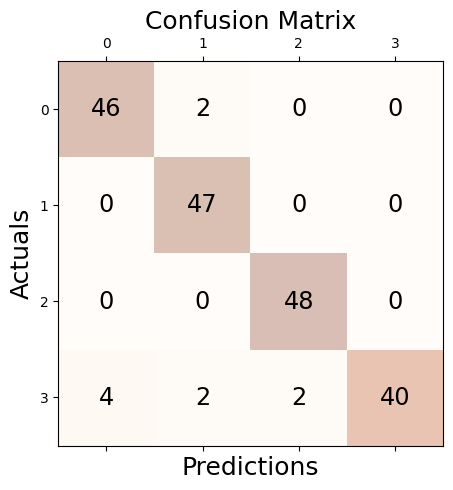

In [ ]:
y_test_val = test_data['CFTR GENOTYPE'].values

y_pred_val = [get_prediction(query) for query in (test_data.loc[:, test_data.columns != 'CFTR GENOTYPE']).to_numpy()]
accuracy = accuracy_score(y_pred_val, y_test_val)
f1 = f1_score(y_pred_val, y_test_val, average='weighted')
precision = precision_score(y_pred_val, y_test_val, average='weighted')
recall = recall_score(y_pred_val, y_test_val, average='weighted')

print(f'Test accuracy (siamese model): {100*accuracy:.2f} %')
print(f'precision (siamese model): {100*precision:.2f} %')
print(f'recall (siamese model): {100*recall:.2f} %')
print(f'f1 (siamese model): {100*f1:.2f} %')
confusionMatrix(y_pred_val, y_test_val)